# Planertary motion

This notebook demonstrates how to use the integrators available in `jwave.ode` by simulating the motion of a planet around a star.

In general, the integrators tries to solve an ODE of the kind

$$
\dot x = f(x,t)
$$

by approximating

$$
x(t) = x(0) + \int_0^t f(x,\tau) d\tau.
$$

For a planet orbiting around a star, assuming the star fixed, the equation of motion (EOM) is given by

$$
\left\{\begin{matrix}
\dot x &=& v\\ 
\dot v &=& G\frac{mr}{\|r\|^3}
\end{matrix}\right.
$$

In [1]:
from jax import numpy as jnp
from matplotlib import pyplot as plt

In [2]:
# Setup
M_sun = 2.0  # kg
p0 = jnp.array([0.0, 3.0])  # m
v0 = jnp.array([1.0, 0.0])  # m/s
G = 1

dt = 0.1
t_end = 200.0
output_steps = (jnp.arange(0, t_end, 10 * dt) / dt).round()

In [3]:
# Define equation of motion
def newton_grav_law(G, M, r):
    """returns the applied force. Assumes Sun in (0,0)"""
    return -r * G * M / (jnp.linalg.norm(r) ** 3)

# The function accepts the pair (p, v) to model the second order
# ODE as a first order ODE (state-space representation)
# Returns the pair (p', v')
f = lambda x, t: (x[1], newton_grav_law(G=1, M=M_sun, r=x[0]))

#### First-Order euler integration

In [4]:
from jwave.ode import euler_integration

The simples integrator uses a first order temporal-difference to approximate the differential equation and then uses the following recursive method to integrate

$$
x^{(n+1)} = x^{(n)} + f(x^{(n)}, t^{(n)})\Delta t 
$$

#### Semi-implicit Euler integration

In [5]:
from jwave.ode import semi_implicit_euler

This integrator assumes that the EOM have a symplectic form

$$
\left\{\begin{matrix}
\dot x &= f_1(y,t)\\ 
\dot y &= f_2(x,t)
\end{matrix}\right.
$$

which is indeed the case for our EOM. However, we should now explicitly define the two differential equations

In [6]:
f_1 = lambda v, t: v
f_2 = lambda p, t: newton_grav_law(G=1, M=M_sun, r=p)

### Solving and comparing the two solutions

Note that the semi-implicit integrator does a much better job in conserving the energy of the system.

In [7]:
p_euler, _     = euler_integration(f, (p0, v0), dt, output_steps, timestep_correction=1.0)
p_semi_impl, _ = semi_implicit_euler(f_1, f_2, p0, v0, dt, output_steps, timestep_correction=1.0)

(-15.079981017112733,
 4.6052700757980345,
 -8.301552605628967,
 7.369081807136536)

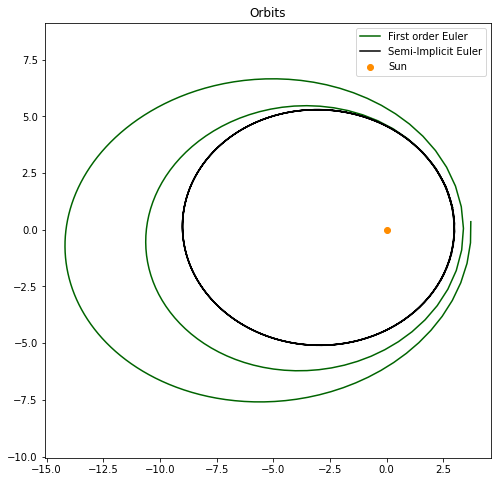

In [8]:
plt.figure(figsize=(8,8))
plt.plot(p_euler[:, 1], p_euler[:, 0], label="First order Euler", color="darkgreen")
plt.plot(p_semi_impl[:, 1], p_semi_impl[:, 0], label="Semi-Implicit Euler", color="black")
plt.scatter(0,0,label="Sun", color="darkorange")
plt.title("Orbits")
plt.legend()
plt.axis("equal")